In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import sys
import os

# Subir tres niveles desde tfm/teams/frankfurt/ hasta data/
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
sys.path.insert(0, project_root)

from database.connection import get_db_manager

In [2]:
# Configuration
TABLE_TYPE = 'domestic'
SEASON = '2223'
MIN_MINUTES = 800

FRANKFURT_COLORS = {
    'primary': '#E1000F',
    'secondary': '#000000'
}

ANTWERP_COLORS = {
    'primary': '#FFFFFF',
    'secondary': '#FFFFFF'
}

DF_PLAYERS = [
    {'name': 'Obite N\'Dicka', 'search': 'N\'Dicka', 'pos': 'DF', 'team': 'Frankfurt'},
    {'name': 'Willian Pacho', 'search': 'Pacho', 'pos': 'DF', 'team': 'Antwerp'},
]

SAVE_PATH_BASE = "./ndicka_pacho_radars/"
os.makedirs(SAVE_PATH_BASE, exist_ok=True)

In [3]:
# Conexión BD - Combinar Big 5 + Belgian league
db = get_db_manager()

big5_leagues = ['ENG-Premier League', 'ESP-La Liga', 'ITA-Serie A', 'GER-Bundesliga', 'FRA-Ligue 1']
league_list_str = "', '".join(big5_leagues)

# Query Big 5 (season 2223)
query_big5 = text(f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.league IN ('{league_list_str}')
AND p.season = '{SEASON}'
ORDER BY p.league, p.season DESC, p.team, p.player_name
""")

# Query Belgian league (season 2223)
query_bel = text(f"""
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    NULL::jsonb as understat_metrics
FROM footballdecoded.players_extras p
WHERE p.league = 'BEL-Pro League'
AND p.season = '{SEASON}'
ORDER BY p.team, p.player_name
""")

try:
    with db.engine.begin() as conn:
        df_big5 = pd.read_sql(query_big5, conn)
        df_bel = pd.read_sql(query_bel, conn)
    
    df_raw = pd.concat([df_big5, df_bel], ignore_index=True)
    
    print(f"Big 5 (2223): {len(df_big5)} | BEL (2223): {len(df_bel)} | Total: {df_raw.shape[0]} registros")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
finally:
    db.close()

df_raw.head()

2026-01-05 17:52:10,761 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2026-01-05 17:52:12,184 - database.connection - INFO - Database connection successful


Big 5 (2223): 2801 | BEL (2223): 532 | Total: 3333 registros


,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,3812f10db382a575,Aaron Ramsdale,Arsenal,ENG-Premier League,2223,GK,ENG,24,"{'CS': '14', 'FK': '0', 'OG': '0', '/90': '-0....","{'understat_xa': '0.0', 'understat_team': 'Ars..."
1,5667bbe8a1e88932,Albert Sambi Lokonga,Arsenal,ENG-Premier League,2223,MF,BEL,22,"{'FK': '0', 'OG': '0', 'Crs': '0', 'Fld': '5',...","{'understat_xa': '0.04567850008606911', 'under..."
2,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2223,DF,ENG,24,"{'CS': '0', 'FK': '0', 'OG': '0', '/90': '0.44...","{'understat_xa': '4.293553752824664', 'underst..."
3,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2223,FW,ENG,20,"{'FK': '1', 'OG': '0', 'Crs': '172', 'Fld': '6...","{'understat_xa': '7.0429807445034385', 'unders..."
4,7e4915975dddbf21,Cédric Soares,Arsenal,ENG-Premier League,2223,DF,POR,30,"{'FK': '0', 'OG': '0', 'Crs': '3', 'Fld': '0',...","{'understat_xa': '0.13160278275609016', 'under..."


In [4]:
# Filtrar por minutos mínimos Y posición DF
df_filtered = df_raw[
    (df_raw['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) >= MIN_MINUTES) &
    (df_raw['position'].str.contains('DF', case=False, na=False))
].copy()

print(f"Filtro {MIN_MINUTES}+ min + DF: {df_filtered.shape[0]} jugadores")

Filtro 800+ min + DF: 844 jugadores


In [5]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    if isinstance(value, (int, float)):
        return float(value)
    
    if value is None or pd.isna(value):
        return np.nan
    
    if isinstance(value, str):
        if value.strip() == '':
            return np.nan
        
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    return np.nan

In [6]:
# Extraer métricas numéricas
fbref_nums = extract_metrics(df_filtered, 'fbref_metrics')
understat_nums = extract_metrics(df_filtered, 'understat_metrics')
print(f"FBref: {fbref_nums.shape[1]} métricas | Understat: {understat_nums.shape[1]} métricas")

FBref: 185 métricas | Understat: 10 métricas


In [7]:
# Métricas a excluir de normalización
exclude_normalization = {
    'minutes_played', 'age', 'birth_year', 'games_started', 'minutes_per_game',
    'minutes_per_start', 'games', 'games_subs', 'unused_sub', 'points_per_game',
    'on_goals_for', 'on_goals_against', 'plus_minus', 'plus_minus_per90',
    'plus_minus_wowy', 'on_xg_for', 'on_xg_against', 'xg_plus_minus',
    'xg_plus_minus_per90', 'xg_plus_minus_wowy', 'Touches_Touches',
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id', 
    'CS%', 'CS', 'PSxG+/-', 'PSxG', 'Save_Save%',
    "Sweeper_#OPA", 'Sweeper_#OPA/90', 'Sweeper_AvgDist', "Goal Kicks_Launch%", 'G-xG'
}

# Calcular per100touches FBref
fbref_per100 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_normalization)]
fbref_per100 = (fbref_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
fbref_per100.columns = [f'{col}_per100touches' for col in fbref_per100.columns]

# Calcular per100touches Understat
understat_per100 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_normalization)]
understat_per100 = (understat_per100.div(fbref_nums['Touches_Touches'], axis=0) * 100).round(3)
understat_per100.columns = [f'{col}_per100touches' for col in understat_per100.columns]

print(f"Per100touches: {fbref_per100.shape[1]} + {understat_per100.shape[1]}")

# COMBINAR todas las métricas
all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per100, understat_per100], axis=1)

Per100touches: 144 + 7


In [8]:
# Calcular percentiles
all_percentiles = all_metrics.rank(pct=True) * 98 + 1
all_percentiles = all_percentiles.round(0).astype('Int64')
all_percentiles.columns = [f'{col}_pct' for col in all_percentiles.columns]

print(f"Métricas totales: {all_metrics.shape[1]}")
print(f"Percentiles totales: {all_percentiles.shape[1]}")

Métricas totales: 346
Percentiles totales: 346


In [9]:
# DataFrame final consolidado
base_cols = ['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']

df_final = pd.concat([
    df_filtered[base_cols],
    all_metrics,
    all_percentiles
], axis=1)

print(f"DataFrame final: {df_final.shape[0]} filas, {df_final.shape[1]} columnas")

# Limpieza de Series anidados
def clean_series_values(df):
    for col in df.columns:
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        if series_mask.any():
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)

# Eliminar columnas problemáticas
problem_cols = ['shots_on_target_pct']
df_final = df_final.drop(columns=[col for col in problem_cols if col in df_final.columns])

print(f"Limpieza completada: {df_final.shape[1]} columnas finales")

DataFrame final: 844 filas, 698 columnas
Limpieza completada: 696 columnas finales


In [10]:
# Search DF players
player_ids = {}

print("DEFENDER PLAYER SEARCH:")
print("=" * 50)

for player_config in DF_PLAYERS:
    player_name = player_config['name']
    search_pattern = player_config['search']
    target_team = player_config.get('team', None)
    
    search_results = df_filtered[
        df_filtered['player_name'].str.contains(search_pattern, case=False, na=False)
    ]
    
    # Filter by team if specified
    if target_team:
        search_results = search_results[
            search_results['team'].str.contains(target_team, case=False, na=False)
        ]
    
    if len(search_results) > 0:
        print(f"\n{player_name} - search: '{search_pattern}':")
        for _, p in search_results.iterrows():
            minutes = p['fbref_metrics'].get('minutes_played', 0) if isinstance(p['fbref_metrics'], dict) else 0
            print(f"  {p['unique_player_id']} - {p['player_name']} ({p['team']}, {p['league']}, {p['position']}) - {minutes} min")
            
            if player_name not in player_ids:
                player_ids[player_name] = p['unique_player_id']
                print(f"  ✓ ASSIGNED: {player_name} -> {p['unique_player_id']}")
                break
    else:
        print(f"\n{player_name}: NOT FOUND")

print("\n" + "=" * 50)
print("PLAYERS FOUND:")
for name, player_id in player_ids.items():
    print(f"  {name}: {player_id}")

if len(player_ids) == 2:
    print(f"\n✓ ALL PLAYERS FOUND")
else:
    print(f"\n✗ MISSING PLAYERS")

DEFENDER PLAYER SEARCH:

Obite N'Dicka - search: 'N'Dicka':
  4b9df4e4815955e5 - Obite N'Dicka (Eint Frankfurt, GER-Bundesliga, DF) - 2692.0 min
  ✓ ASSIGNED: Obite N'Dicka -> 4b9df4e4815955e5

Willian Pacho - search: 'Pacho':
  3b6c6d66fee0938d - Willian Pacho (Antwerp, BEL-Pro League, DF) - 2895.0 min
  ✓ ASSIGNED: Willian Pacho -> 3b6c6d66fee0938d

PLAYERS FOUND:
  Obite N'Dicka: 4b9df4e4815955e5
  Willian Pacho: 3b6c6d66fee0938d

✓ ALL PLAYERS FOUND


In [11]:
# CB metrics configuration
df_metrics = [
    'pass_completion_pct', 'Challenges_Tkl%', 'Aerial Duels_Won_per100touches', 'Aerial Duels_Won%',
    'passes_final_third_per100touches', 'clearances_per100touches', 'progressive_passes_per100touches', 'Tkl+Int_per100touches',
    'interceptions_per100touches', 'Blocks_Sh_per100touches'
]
df_titles = [
    'Pass Accuracy %', 'Tackle Success %', 'Aerial Duels Won', 'Aerial Success %',
    'Final Third Passes', 'Clearances', 'Progressive Passes', 'Tackles + Interceptions',
    'Interceptions', 'Shot Blocks'
]

METRICS_BY_POSITION = {
    'df_cb': {'metrics': df_metrics, 'titles': df_titles}
}

print("CB METRICS VERIFICATION:")
print("=" * 50)
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

CB METRICS VERIFICATION:
OK df_cb: 10 metrics, 10 titles


In [12]:
# Ndicka vs Pacho comparison configuration
COMPARISON = {
    'name': 'Ndicka_vs_Pacho',
    'player1': 'Obite N\'Dicka',
    'player2': 'Willian Pacho',
    'position_type': 'DF_CB',
    'metrics_key': 'df_cb',
    'title': 'Obite N\'Dicka vs Willian Pacho (22/23)',
    'faces': ['/home/jaime/FD/data/blog/caras/tfm/ndicka.png', '/home/jaime/FD/data/blog/caras/tfm/pacho.png'],
    'colors': [FRANKFURT_COLORS['primary'], ANTWERP_COLORS['primary']]
}

print(f"COMPARISON: {COMPARISON['title']}")
print(f"\nMETRICS BY POSITION:")
for position, config in METRICS_BY_POSITION.items():
    metrics_count = len(config['metrics'])
    titles_count = len(config['titles'])
    status = "OK" if metrics_count == 10 and titles_count == 10 else "ERROR"
    print(f"{status} {position}: {metrics_count} metrics, {titles_count} titles")

COMPARISON: Obite N'Dicka vs Willian Pacho (22/23)

METRICS BY POSITION:
OK df_cb: 10 metrics, 10 titles


DF/CB PLAYER RADAR GENERATION

Processing: Obite N'Dicka vs Willian Pacho (22/23)
  Dataset: 844 players (DF)
  Teams: Eint Frankfurt vs Antwerp
  Colors: ['#E1000F', '#FFFFFF']
  ✓ Completed: Ndicka_vs_Pacho_combined.png


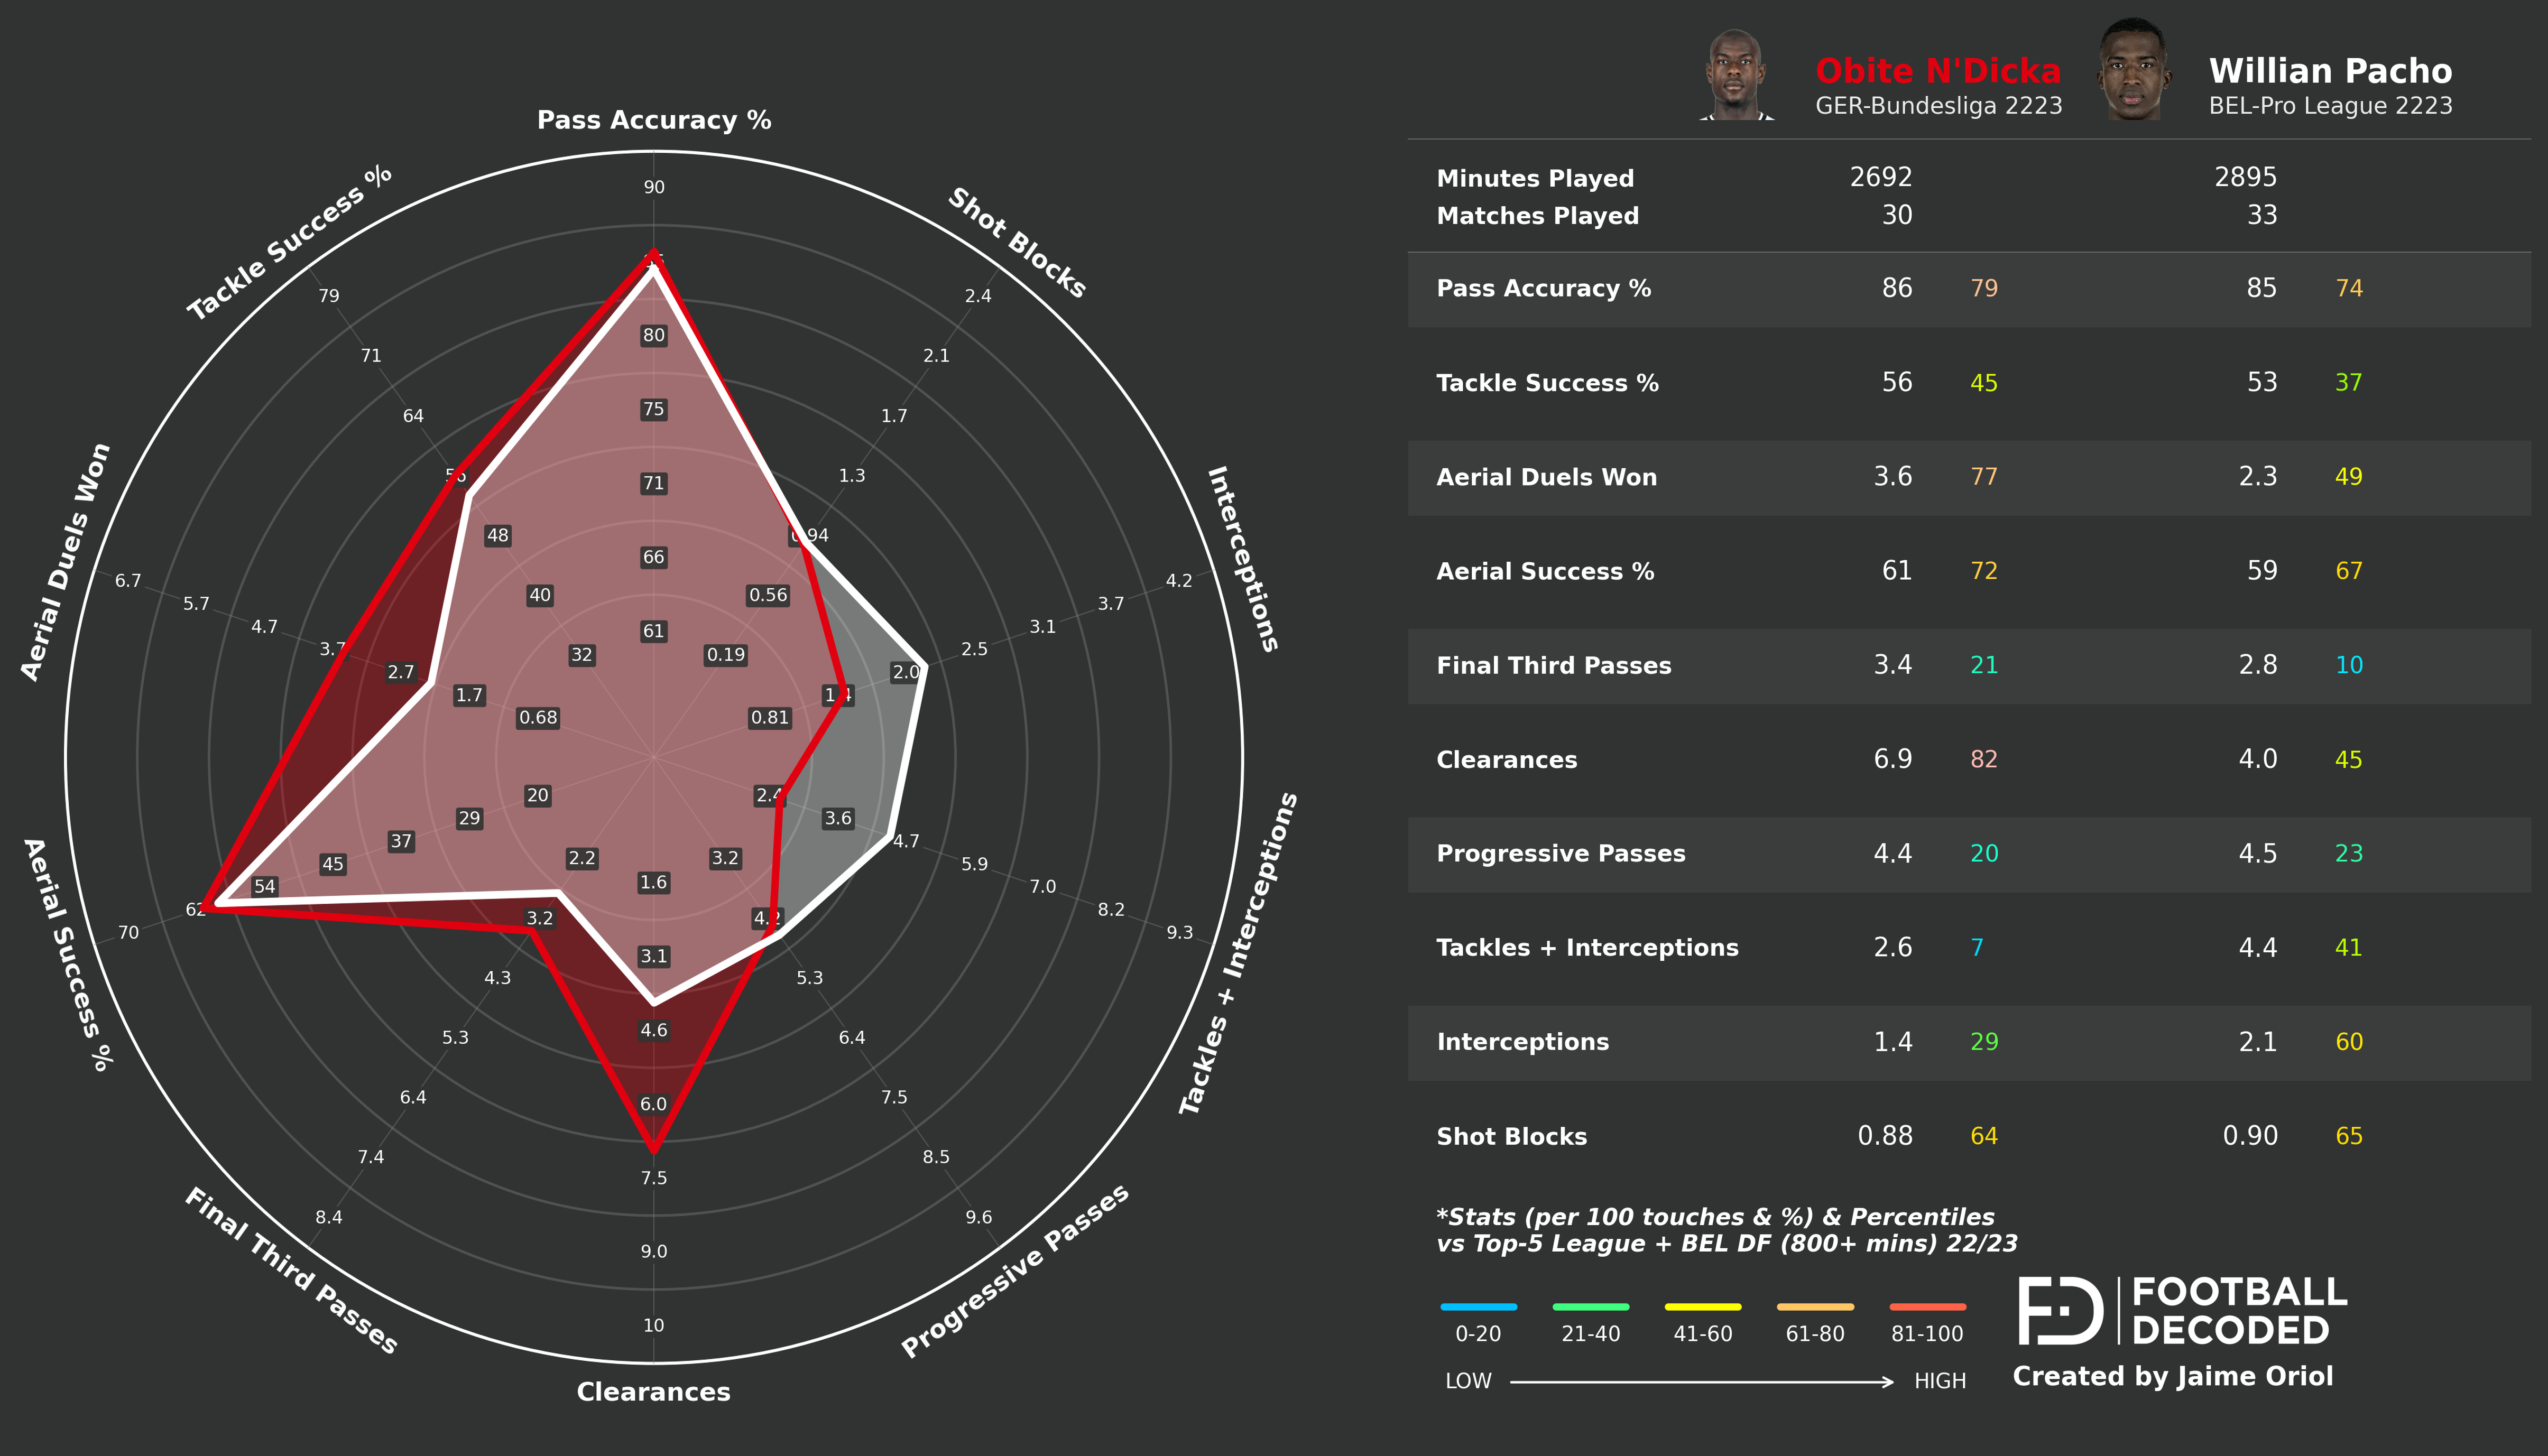


RADAR COMPARISON SUMMARY
✓ Radar generated successfully
Files saved in: ./ndicka_pacho_radars/


In [13]:
from viz.swarm_radar import create_player_radar
from viz.stats_radar import create_stats_table, combine_radar_and_table
from IPython.display import Image as IPImage, display

print("DF/CB PLAYER RADAR GENERATION")
print("=" * 50)

comparison = COMPARISON
config_name = comparison['name']
player1_name = comparison['player1'] 
player2_name = comparison['player2']
title = comparison['title']
faces = comparison['faces']
colors = comparison['colors']
metrics_key = comparison['metrics_key']

print(f"\nProcessing: {title}")

if player1_name not in player_ids or player2_name not in player_ids:
    print(f"Missing player ID")
    print(f"  {player1_name}: {'Found' if player1_name in player_ids else 'Missing'}")
    print(f"  {player2_name}: {'Found' if player2_name in player_ids else 'Missing'}")
else:
    player1_id = player_ids[player1_name]
    player2_id = player_ids[player2_name]
    
    metrics_config = METRICS_BY_POSITION[metrics_key]
    metrics = metrics_config['metrics']
    metric_titles = metrics_config['titles']
    
    # Dataset DF
    position_df = df_final[df_final['position'].str.contains('DF', case=False, na=False)].copy()
    position_filter = "DF"
    
    print(f"  Dataset: {position_df.shape[0]} players ({position_filter})")
    
    # Team names
    player1_team = df_final.loc[df_final['unique_player_id'] == player1_id, 'team'].iloc[0]
    player2_team = df_final.loc[df_final['unique_player_id'] == player2_id, 'team'].iloc[0]
    
    team_colors = colors
    team_logos = {}
    if faces[0]:
        team_logos[player1_team] = faces[0]
    if len(faces) > 1 and faces[1]:
        team_logos[player2_team] = faces[1]
    
    print(f"  Teams: {player1_team} vs {player2_team}")
    print(f"  Colors: {colors}")
    
    try:
        create_player_radar(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            save_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            use_swarm=False,
            show_plot=False
        )
        
        create_stats_table(
            df_data=position_df,
            player_1_id=player1_id,
            player_2_id=player2_id,
            metrics=metrics,
            metric_titles=metric_titles,
            team_colors=team_colors,
            team_logos=team_logos,
            save_path=f"{SAVE_PATH_BASE}{config_name}_table.png",
            footer_text=f"Stats (per 100 touches & %) & Percentiles\nvs Top-5 League + BEL {position_filter} ({MIN_MINUTES}+ mins) 22/23",
            show_plot=False
        )
        
        combine_radar_and_table(
            radar_path=f"{SAVE_PATH_BASE}{config_name}_radar.png",
            table_path=f"{SAVE_PATH_BASE}{config_name}_table.png", 
            output_path=f"{SAVE_PATH_BASE}{config_name}_combined.png"
        )
        
        print(f"  ✓ Completed: {config_name}_combined.png")
        
        display(IPImage(f"{SAVE_PATH_BASE}{config_name}_combined.png"))
        
        print("\n" + "=" * 50)
        print("RADAR COMPARISON SUMMARY")
        print("=" * 50)
        print(f"✓ Radar generated successfully")
        print(f"Files saved in: {SAVE_PATH_BASE}")
        
    except Exception as e:
        print(f"  ✗ Error: {str(e)}")
        import traceback
        traceback.print_exc()